# Medical Cost Personal Dataset

### Context
Machine Learning with R by Brett Lantz is a book that provides an introduction to machine learning using R. As far as I can tell, Packt Publishing does not make its datasets available online unless you buy the book and create a user account which can be a problem if you are checking the book out from the library or borrowing the book from a friend. All of these datasets are in the public domain but simply needed some cleaning up and recoding to match the format in the book.

Dataset downloaded from Kaggle

In [127]:
# import Libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
from scipy.stats import boxcox
from scipy.stats.mstats import normaltest
from sklearn.model_selection import train_test_split, KFold, cross_val_predict, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
import warnings
from sklearn.exceptions import ConvergenceWarning


In [128]:
data = pd.read_csv('insurance.csv')

There are no NaN values in this dataset

## EDA

In [129]:
data.shape

(1338, 7)

In [130]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [131]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
age,1338.0,39.207025,14.049960,18.0000,27.00000,39.000,51.000000,64.00000
bmi,1338.0,30.663397,6.098187,15.9600,26.29625,30.400,34.693750,53.13000
children,1338.0,1.094918,1.205493,0.0000,0.00000,1.000,2.000000,5.00000
charges,1338.0,13270.422265,12110.011237,1121.8739,4740.28715,9382.033,16639.912515,63770.42801


### Checking for missing values

In [132]:
data.isnull().any()

age         False
sex         False
bmi         False
children    False
smoker      False
region      False
charges     False
dtype: bool

There is no missing values in the dataset.

### Plots

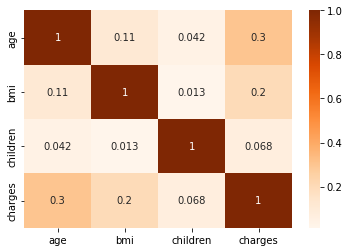

In [133]:
# correlation plot
corr = data.corr()
sns.heatmap(corr, cmap = 'Oranges', annot= True);


In the correlation matrix, among the three numeric variables, age exhibits the highest correlation with 'charges', followed by BMI and then children. Age shows the strongest positive correlation with 'charges', indicating that as age increases, insurance charges tend to increase as well. BMI also shows a positive correlation with 'charges', albeit to a lesser extent compared to age. On the other hand, the correlation between children and 'charges' is relatively weak, with a correlation coefficient of 0.068. This suggests that children may not be a highly influential factor in determining insurance charges, and including it in the model may not significantly improve predictive performance.

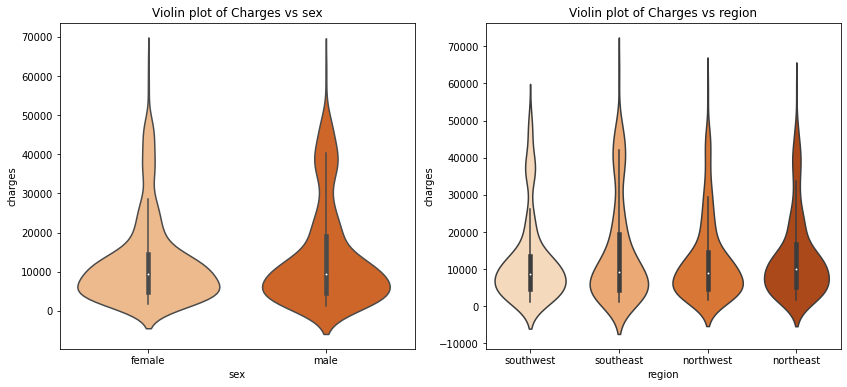

In [134]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='sex', y='charges',data=data,palette='Oranges',ax=ax)
ax.set_title('Violin plot of Charges vs sex')

ax = f.add_subplot(122)
sns.violinplot(x='region', y='charges',data=data,palette='Oranges',ax=ax)
ax.set_title('Violin plot of Charges vs region');


In the sex violin plots, the averages between males and females appear to be nearly identical, indicating similar central tendencies in insurance charges for both genders. However, the 1.5x interquartile range (the length of the 'tails' of the violins) is higher for males compared to females. This suggests that while the central tendency is similar, there is greater variability in insurance charges for males, with some males having significantly higher charges than the majority.

In the second violin chart depicting insurance charges across different regions, the medians are consistent across all regions, indicating similar central tendencies in insurance charges regardless of region. However, there are differences in the shapes of the distributions. Southeast exhibits the largest peak, indicating a concentration of individuals with relatively lower insurance charges, while southwest has the smallest peak, suggesting fewer individuals with lower charges in this region. These variations in peak heights suggest differing distributions of insurance charges across regions, despite similar median values.

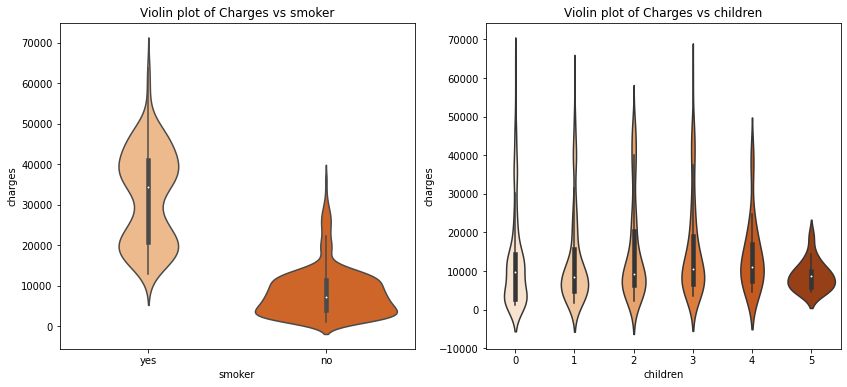

In [135]:
f = plt.figure(figsize=(14,6))
ax = f.add_subplot(121)
sns.violinplot(x='smoker', y='charges',data=data,palette='Oranges',ax=ax)
ax.set_title('Violin plot of Charges vs smoker');

ax = f.add_subplot(122)
sns.violinplot(x='children', y='charges',data=data,palette='Oranges',ax=ax)
ax.set_title('Violin plot of Charges vs children');

In the first violin plot, smokers exhibit noticeably higher insurance charges compared to non-smokers, with the median insurance cost for smokers being around $20,000 more than that of non-smokers. This suggests a significant impact of smoking status on insurance charges.

In the second violin plot, the number of children shows a relatively consistent median across all categories, with each category having a similar central tendency. However, there are notable differences in the tails of the distribution. The largest peak is observed for customers with no children, indicating a higher concentration of individuals in this category with lower insurance charges. Conversely, customers with five children exhibit the lowest peak, suggesting fewer individuals in this category and potentially higher insurance charges on average. Additionally, the violin plot for customers with five children appears noticeably more condensed compared to the other categories. This indicates a narrower range of insurance charges for customers with five children, possibly reflecting a more homogeneous subgroup within the dataset.

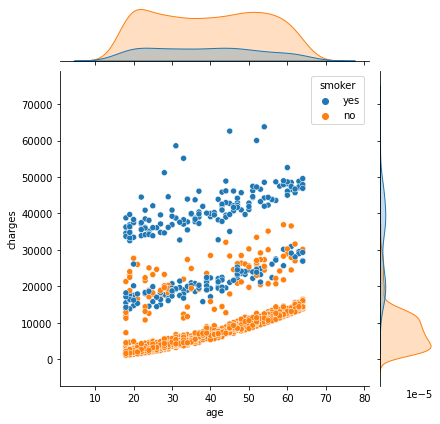

In [136]:
sns.jointplot(data=data, x="age", y="charges", hue="smoker")
ax.set_title('Joint Plot of Charges vs Age with Smoker Hue');

As age increases, the insurance cost tends to rise for both smokers and non-smokers. However, smokers generally incur higher charges compared to non-smokers across all age groups. This indicates that while age is a factor contributing to increased insurance costs for both groups, smoking status plays a significant role in determining the extent of these charges, with smokers experiencing higher costs regardless of age.

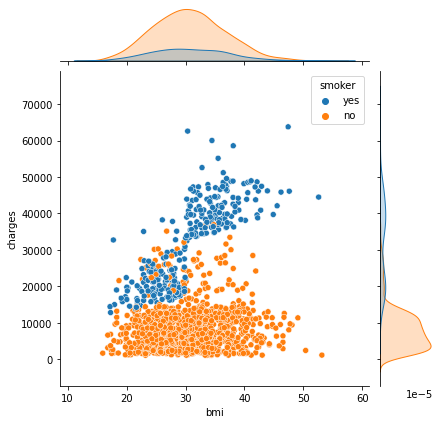

In [137]:
sns.jointplot(data=data, x="bmi", y="charges", hue="smoker")
ax.set_title('Joint Plot of Charges vs BMI with Smoker Hue');

In the joint plot, when patients are smokers, higher BMI tends to correlate with higher insurance charges, indicating that higher BMI might lead to increased insurance costs for smokers. However, for non-smokers, while there is still a positive relationship between BMI and insurance charges, it appears to be less pronounced compared to smokers. This suggests that BMI may have a less significant impact on insurance charges for non-smokers compared to smokers.

In [138]:
data.region.value_counts()

southeast    364
southwest    325
northwest    325
northeast    324
Name: region, dtype: int64

### Data Preprocessing

I will be using one-hot encoding for the 3 catergorical features. one-hot encoding preserves all the information contained in the categorical variable. Each category is represented by its own binary dummy variable, allowing the model to learn the relationship between each category and the target variable independently.

In [139]:
df_encoded = pd.get_dummies(data, columns=['sex', 'smoker', 'region'],drop_first =True)
df_encoded.corr()['charges'].sort_values()

region_southwest   -0.043210
region_northwest   -0.039905
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

In [140]:
df_encoded2 = pd.get_dummies(data, columns=['sex', 'smoker', 'region'])
df_encoded2.corr()['charges'].sort_values()

smoker_no          -0.787251
sex_female         -0.057292
region_southwest   -0.043210
region_northwest   -0.039905
region_northeast    0.006349
sex_male            0.057292
children            0.067998
region_southeast    0.073982
bmi                 0.198341
age                 0.299008
smoker_yes          0.787251
charges             1.000000
Name: charges, dtype: float64

Lastly, looking at our target variable.

<AxesSubplot: xlabel='charges', ylabel='Count'>

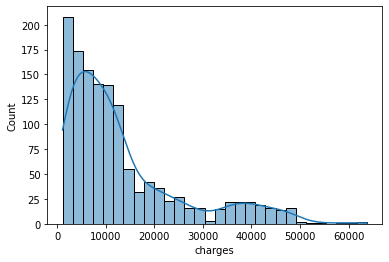

In [141]:
sns.histplot(data=data, x='charges', kde=True)

In [142]:
t_skew = data['charges'].skew()

if t_skew > 1:
    print("Charges does not have a normal distribution.")
    print("The skewness value is ", round(t_skew,3), " meaning it has a positive or right skew")
elif t_skew < -1:
    print("Charges does not have a normal distribution.")
    print("The skewness value is ", round(t_skew,3), " meaning it has a negative or left skew")
else: 
    print("Charges does have a normal distribution with a skew value of ", round(t_skew,3))
    print("The skewness value is ", round(t_skew,3), " meaning it has a negative or left skew")


Charges does not have a normal distribution.
The skewness value is  1.516  meaning it has a positive or right skew


The target variable does not follow a normal distribution. There is another way to determine if the target variable follow a normal distribution.       
By using the normal test from the scipy library, it will suggest that the data significantly deviates from a normal distribution if the p-values is less than 0.05.        
For the normality test, the null and alternative hypotheses are as follows:   

Null Hypothesis (H<sub>0): The data follows a normal distribution.

Alternative Hypothesis (H<sub>1): The data does not follow a normal distribution

In [143]:
normaltest(data.charges.values)

NormaltestResult(statistic=336.8851220567733, pvalue=7.019807901276197e-74)

The p-value is less than 0.05, so we reject the null hypothesis.   

Looking at the distribution, it might be beneficial to do target variable transformation. 
We will try 3 different transformations:   
* Log Transformation
* Square root Transformation
* Box cox Transformation

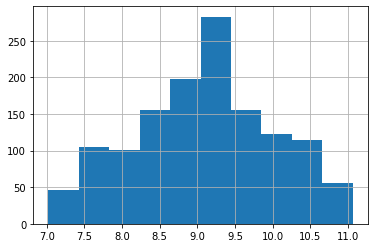

In [144]:
# Log Transformation
log_charge = np.log(data.charges)
log_charge.hist();

In [145]:
normaltest(log_charge)

NormaltestResult(statistic=52.71670509113935, pvalue=3.5703676381337117e-12)

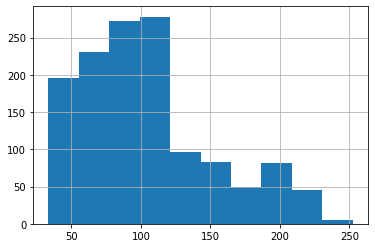

In [146]:
# Square root Transformation
sqrt_charge = np.sqrt(data.charges)
sqrt_charge.hist();

In [147]:
normaltest(sqrt_charge)

NormaltestResult(statistic=112.4605295472106, pvalue=3.7975744156203163e-25)

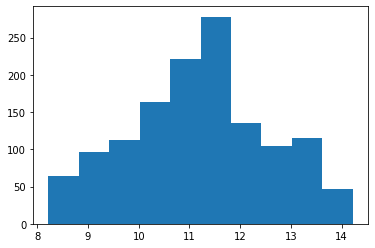

In [148]:
# Box cox Transformation
bc_result = boxcox(data.charges)
bc_charge = bc_result[0]
lam = bc_result[1]
plt.hist(bc_charge);

In [149]:
normaltest(bc_charge)

NormaltestResult(statistic=54.4181017156977, pvalue=1.5249631686757668e-12)

After attempting three different transformations (sqrt, log, and Box-Cox) on the target variable, the resulting p-values from the normality tests remained below 0.05. While achieving a normal distribution in the target variable would be beneficial for linear regression analysis, it's important to note that strict adherence to normality assumptions is not always necessary for linear regression to provide useful insights. Linear regression is robust to violations of normality assumptions, particularly when the sample size is large. However, departures from normality can affect the efficiency and interpretation of the estimates, so it's essential to consider the implications of non-normality on the validity of the regression results.

## Model 
### Test Train Split

In [150]:
X = df_encoded.drop('charges',axis=1) # Independet variable
y = df_encoded['charges'] # dependent variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

### Model Building

I am constructing a base linear regression model without incorporating Lasso and Ridge regularization techniques as an initial benchmark. Subsequently, I will introduce Lasso and Ridge regularization to assess whether these techniques enhance the performance of the base model. This comparative approach allows for an evaluation of the incremental benefits that Lasso and Ridge regularization may provide in improving the model's predictive capabilities and interpretability

<u>Base Model</u>

In [151]:
# base model
lr = LinearRegression()
lr.fit(X_train,y_train)
y_pred = lr.predict(X_test)
base_model_score = r2_score(y_test, y_pred)
base_model_score

0.7696118054369011

<u>Scaler and Polynomial Features</u>

In [162]:
lr = LinearRegression()

pf = PolynomialFeatures(degree=2, include_bias=False)
X_pf = pf.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_pf, y, test_size=0.3, random_state=42)

s = StandardScaler()
X_train_s = s.fit_transform(X_train)

lr.fit(X_train_s, y_train)

X_test_s = s.transform(X_test)
y_pred = lr.predict(X_test_s)

sp_score = r2_score(y_test, y_pred)
sp_score

0.8606056771025021

A significant increase in the R<sup>2</sup> score from 0.769 to 0.860 after adding a scaler and polynomial features indicates that these preprocessing steps have had a substantial positive impact on the performance of the linear regression model. 

<u>k-Fold Cross Validation</u>

We aim to determine the optimal number of folds k for cross-validation in our regression model, ranging from 3 to 10, by systematically evaluating mean R<sup>2</sup> scores obtained through k-fold cross-validation. Utilizing the sklearn library, we implement a loop to assess each k value's performance, considering shuffled data and a fixed random state for consistency. The selected k value will inform future model training, ensuring robustness and generalization to new data, thus enhancing the reliability and accuracy of our predictive modeling outcomes.

In [153]:
pf = PolynomialFeatures(degree=2, include_bias=False)
s = StandardScaler()
lr = LinearRegression()

estimator = Pipeline([("poly", pf), ("scaler", s), ("regression", lr)])

num_folds = range(3, 11) 
mean_scores = []

for folds in num_folds:
    kf = KFold(shuffle=True, random_state=72018, n_splits=folds)
    scores = cross_val_score(estimator, X, y, cv=kf, scoring='r2')
    mean_scores.append(np.mean(scores))

# Find the optimal number of folds with the highest mean score
optimal_num_folds = num_folds[np.argmax(mean_scores)]
best_mean_score = mean_scores[np.argmax(mean_scores)]

print("Optimal number of folds:", optimal_num_folds)
print("Mean R^2 score with optimal number of folds:", best_mean_score)

k_fold_score = best_mean_score

Optimal number of folds: 9
Mean R^2 score with optimal number of folds: 0.8359374255089215


<u>Lasso Regression</u>


Lasso regression is particularly useful when dealing with high-dimensional datasets, as it automatically performs feature selection by shrinking less important features to zero. Additionally, its regularization penalty helps mitigate multicollinearity issues, making it robust against correlated predictors.

In [154]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures(include_bias=False)),
        ("lasso_regression", Lasso(max_iter=100000))])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'lasso_regression__alpha': [0.01,0.1, 1]
}

grid = GridSearchCV(estimator, params, cv=kf)

In [155]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore", category=ConvergenceWarning)
    
    grid.fit(X_train, y_train)

In [156]:
grid.best_score_ , grid.best_params_

(0.8176376698059105,
 {'lasso_regression__alpha': 1, 'polynomial_features__degree': 2})

In [157]:
y_predict = grid.predict(X_test)
lasso_grid_score = r2_score(y_test, y_predict)

<u>Ridge Regression</u>

Ridge regression is advantageous for linear regression modeling when dealing with multicollinearity among predictors, as it effectively shrinks the coefficients of correlated features while still maintaining their importance in the model. Furthermore, Ridge regression provides improved stability and generalization performance by reducing the variance of parameter estimates, making it a valuable tool for achieving robust and reliable predictions.

In [158]:
estimator = Pipeline([("scaler", StandardScaler()),
        ("polynomial_features", PolynomialFeatures()),
        ("ridge_regression", Ridge())])

params = {
    'polynomial_features__degree': [1, 2, 3],
    'ridge_regression__alpha': np.geomspace(0.01, 20, 50)
}

grid = GridSearchCV(estimator, params, cv=kf)
grid.fit(X_train, y_train)
grid.best_score_ , grid.best_params_

(0.8180341176839058,
 {'polynomial_features__degree': 2, 'ridge_regression__alpha': 20.0})

In [159]:
y_predict = grid.predict(X_test)
ridge_score = r2_score(y_test, y_predict)

In [163]:
r2_vals = [base_model_score, sp_score, k_fold_score, lasso_grid_score, ridge_score]

labels = ['Base LR', 'Scaler and Polynomial Features', 'K-Fold CV', 'Lasso', 'Ridge']

r2_df = pd.Series(r2_vals, index=labels).to_frame()
r2_df.rename(columns={0: 'R2 Score'}, inplace=1)
r2_df

,R2 Score
Base LR,0.769612
Scaler and Polynomial Features,0.860606
K-Fold CV,0.835937
Lasso,0.860654
Ridge,0.861101


Among the various linear regression models examined, Ridge regression emerged as the top performer, achieving an impressive R<sup>2</sup> score of 0.861101